In [1]:
from pathlib import Path
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(Path().resolve(), '../..')))
from ImportHelper import ImportHelper
ImportHelper()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
#from tensorflow import keras
from sklearn import preprocessing
from AlphaVantageCommodities import AlphaVantageCommodities
from PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv
import seaborn as sns
import datetime

load_dotenv()

2023-12-03 20:17:37.654338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 20:17:37.654404: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 20:17:37.654430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 20:17:37.660230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2023-12-03 20:17:41.171269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 20:17:41.176819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 20:17:41.177344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


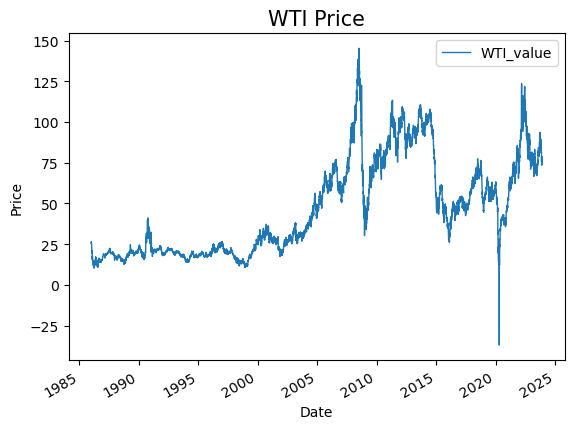

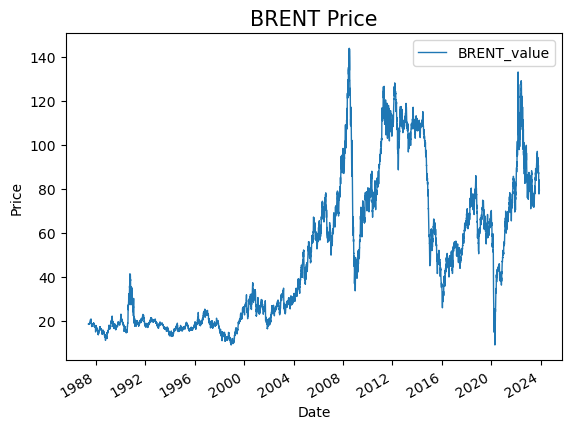

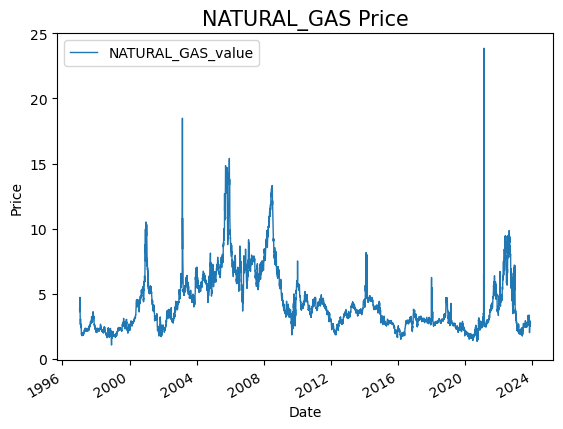

In [4]:
avc = AlphaVantageCommodities()
for symbol in avc.get_all_curated_series_ids():
    avc.plot_series_id(symbol)

In [5]:
df_merged = avc.get_data_as_pandas_df_multiple_series_ids(['WTI','BRENT','NATURAL_GAS'])

In [6]:
# keep nas for masking layer test
#df_merged = df_merged.dropna()

In [7]:
#df_merged = df_merged.dropna(subset=['WTI_value']).fillna(0)

In [8]:
df_merged = df_merged[df_merged['date'].ge('2022-01-01')]

In [9]:
df_merged.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9072,2022-01-03,75.989998,78.250000,3.74
9073,2022-01-04,77.000000,79.389999,3.73
9074,2022-01-05,77.830002,80.599998,3.78
9075,2022-01-06,79.470001,81.989998,3.94
9076,2022-01-07,79.000000,82.279999,3.83


<Axes: xlabel='date'>

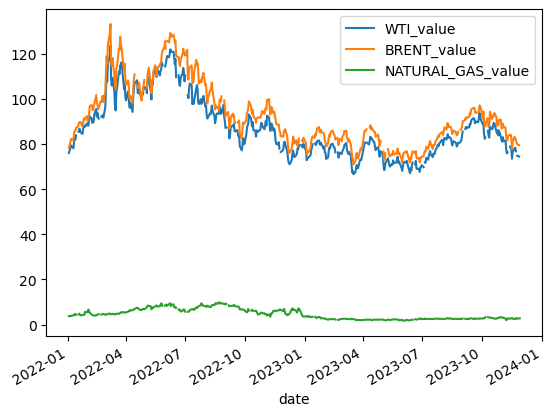

In [10]:
df_merged.plot(x="date")

<Axes: >

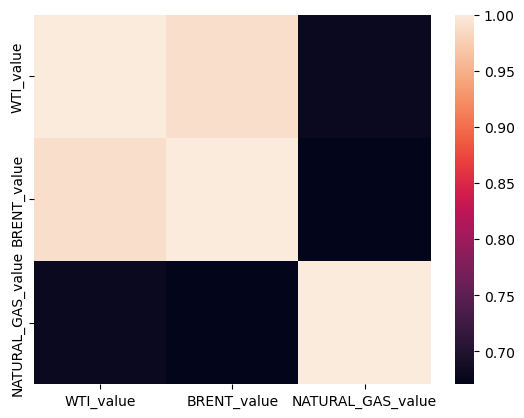

In [11]:
df_corr = df_merged.corr(numeric_only=True)
sns.heatmap(df_corr)

In [12]:
# Normalize data
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df_merged,'WTI_value')

normalizer_brent = PandasDataFrameNormalizer()
df_normalized = normalizer_brent.normalize_pandas_data_frame_column(df_merged,'BRENT_value')

normalizer_natural_gas = PandasDataFrameNormalizer()
df_normalized = normalizer_natural_gas.normalize_pandas_data_frame_column(df_merged,'NATURAL_GAS_value')

In [13]:
df_normalized.tail()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9545,2023-11-22,0.178678,0.172647,0.120838
9703,2023-11-23,NaN,0.158005,NaN
9546,2023-11-24,0.144135,0.141432,0.120838
9547,2023-11-27,0.137647,0.136122,0.123305
9717,2023-11-28,NaN,NaN,0.128237


In [14]:
df_normalized = df_normalized.dropna(subset=['WTI_value']).fillna(-1)

In [15]:
df_normalized.head()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9072,2022-01-03,0.164475,0.116171,0.246609
9073,2022-01-04,0.182185,0.134513,0.245376
9074,2022-01-05,0.196739,0.153982,0.251541
9075,2022-01-06,0.225495,0.176348,0.271270
9076,2022-01-07,0.217254,0.181014,0.257706


<Axes: xlabel='date'>

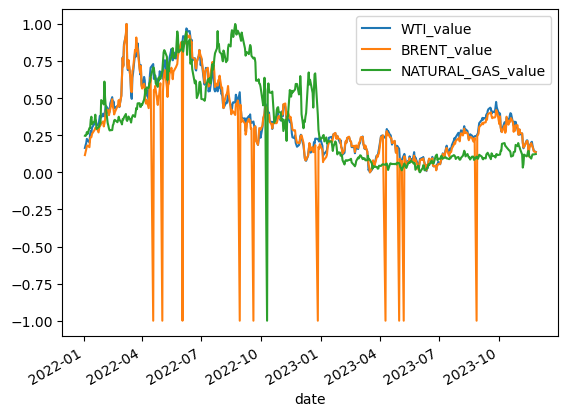

In [16]:
df_normalized.plot(x="date")

In [17]:
data = df_normalized[['WTI_value','BRENT_value','NATURAL_GAS_value']].to_numpy()
data

array([[0.1644748 , 0.11617059, 0.2466091 ],
       [0.18218482, 0.1345133 , 0.24537607],
       [0.19673859, 0.15398231, 0.2515413 ],
       ...,
       [0.17867793, 0.1726469 , 0.12083846],
       [0.14413469, 0.14143205, 0.12083846],
       [0.13764682, 0.13612229, 0.12330455]], dtype=float32)

In [18]:
data.size

1428

In [19]:
np.shape(data)

(476, 3)

In [20]:
print('Data lenght: ' + str(len(data)))

Data lenght: 476


In [21]:
left_size = 0.8
split_at = int(left_size * len(data))
print('Split at: ' + str(split_at))

Split at: 380


In [22]:
forecasting_label_steps = 1
feature_sequence_length = 30

x_train = data[0:split_at]
x_train_data = x_train[:-(feature_sequence_length+forecasting_label_steps)]
x_train_targets = x_train[feature_sequence_length+forecasting_label_steps:, 0]

x_test = data[split_at+1:]
x_test_data = x_test[:-(feature_sequence_length+forecasting_label_steps)]
x_test_targets = x_test[feature_sequence_length+forecasting_label_steps:, 0]

In [23]:
len(x_train_data)

349

In [24]:
len(x_train_targets)

349

In [25]:
len(x_test_data)

64

In [26]:
x_train_data[100:,0]

array([0.86936706, 0.8477994 , 0.83762926, 0.8530598 , 0.88146585,
       0.9181133 , 0.90829396, 0.9282834 , 0.9701912 , 0.96282655,
       0.9489743 , 0.9523058 , 0.9172365 , 0.85411185, 0.8933894 ,
       0.7531124 , 0.76941955, 0.69454676, 0.68630546, 0.7445204 ,
       0.78607756, 0.82500446, 0.7897598 , 0.7215501 , 0.76608807,
       0.61266005, 0.590917  , 0.6664914 , 0.7043661 , 0.6922672 ,
       0.54497635, 0.55812734, 0.5467298 , 0.5782921 , 0.6640365 ,
       0.6927933 , 0.6635104 , 0.55812734, 0.545327  , 0.58250046,
       0.545853  , 0.58600736, 0.56987554, 0.60845166, 0.5256882 ,
       0.53533226, 0.46712255, 0.4327547 , 0.44117126, 0.47185686,
       0.46589515, 0.4921971 , 0.53322804, 0.49535334, 0.44941255,
       0.39663342, 0.4250394 , 0.46624577, 0.47238302, 0.4701034 ,
       0.5234087 , 0.5069261 , 0.46852538, 0.47378567, 0.5398913 ,
       0.44660708, 0.41171306, 0.35910916, 0.36261618, 0.3636682 ,
       0.27862528, 0.30562863, 0.3622654 , 0.378222  , 0.37226

In [27]:
x_train_data

array([[0.1644748 , 0.11617059, 0.2466091 ],
       [0.18218482, 0.1345133 , 0.24537607],
       [0.19673859, 0.15398231, 0.2515413 ],
       ...,
       [0.08697175, 0.07063556, 0.07768185],
       [0.09118003, 0.07626707, 0.06905054],
       [0.10976683, 0.09058738, 0.05918619]], dtype=float32)

In [28]:
x_train_targets

array([0.4772927 , 0.44134665, 0.43222868, 0.4471331 , 0.4476591 ,
       0.45870587, 0.4395932 , 0.51762223, 0.64965814, 0.77380323,
       0.72032267, 0.86200243, 0.92319834, 1.        , 0.7399614 ,
       0.6894617 , 0.7487287 , 0.64194286, 0.52270734, 0.49517795,
       0.6375592 , 0.66771877, 0.79835176, 0.7788883 , 0.846572  ,
       0.834473  , 0.8695423 , 0.71786785, 0.6600035 , 0.7224268 ,
       0.59477466, 0.5735578 , 0.6431703 , 0.6202    , 0.5221813 ,
       0.5162196 , 0.55654913, 0.4841312 , 0.5945993 , 0.6601789 ,
       0.70541817, 0.72996664, 0.6300193 , 0.63036996, 0.65369105,
       0.63563037, 0.5784674 , 0.6314221 , 0.6198492 , 0.68139577,
       0.6659652 , 0.6763107 , 0.62984395, 0.7229528 , 0.72873926,
       0.75591797, 0.63948804, 0.5809223 , 0.6819218 , 0.6933193 ,
       0.76994556, 0.8321936 , 0.8013326 , 0.7550412 , 0.79957914,
       0.80694366, 0.7664387 , 0.805541  , 0.81132734, 0.86936706,
       0.8477994 , 0.83762926, 0.8530598 , 0.88146585, 0.91811

In [29]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=10)

2023-12-03 20:17:43.172882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 20:17:43.174776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 20:17:43.176353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 20:17:43.494828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 20:17:43.495105: I tensorflow/compile

In [30]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=10)

In [31]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (10, 30, 3)
Target shape: (10,)


In [32]:
model = Sequential()

model.add(InputLayer(input_shape = (inputs.shape[1], inputs.shape[2])))

model.add(Masking(mask_value=-1))
#model.add(Dropout(0.2))

model.add(Dense(inputs.shape[2], kernel_initializer='he_uniform'))

#model.add(BatchNormalization())

model.add(LSTM(units = 50, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 200, return_sequences= True))
#model.add(Dropout(0.2))

#model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 3)             0         
                                                                 
 dense (Dense)               (None, 30, 3)             12        
                                                                 
 batch_normalization (Batch  (None, 30, 3)             12        
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 30, 50)            10800     
                                                                 
 dense_1 (Dense)             (None, 30, 1)             51        
                                                                 
Total params: 10875 (42.48 KB)
Trainable params: 10869 (42.46 KB)
Non-trainable params: 6 (24.00 Byte)
___________________

In [33]:
dt = datetime.datetime.now()
path_checkpoint = str(dt) + "_model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [34]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [35]:
history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2023-12-03 20:17:49.507161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-03 20:17:49.524427: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8bfc29a940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 20:17:49.524478: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-03 20:17:49.529273: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-03 20:17:49.622425: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - ETA: 0s - loss: 0.1664 - root_mean_squared_error: 0.4080 - mean_absolute_error: 0.3221
Epoch 1: val_loss improved from inf to 0.04078, saving model to 2023-12-03 20:17:44.908656_model_multi_checkpoint.h5
32/32 [==============================] - 7s 70ms/step - loss: 0.1664 - root_mean_squared_error: 0.4080 - mean_absolute_error: 0.3221 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2052 - val_mean_absolute_error: 0.1877
Epoch 2/100
31/32 [============================>.] - ETA: 0s - loss: 0.0925 - root_mean_squared_error: 0.3041 - mean_absolute_error: 0.2529
Epoch 2: val_loss improved from 0.04078 to 0.02963, saving model to 2023-12-03 20:17:44.908656_model_multi_checkpoint.h5
32/32 [==============================] - 1s 31ms/step - loss: 0.0901 - root_mean_squared_error: 0.3002 - mean_absolute_error: 0.2485 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1746 - val_mean_absolute_error: 0.1525
Epoch 3/100
31/32 [===========================

In [36]:
#history.history

<Axes: >

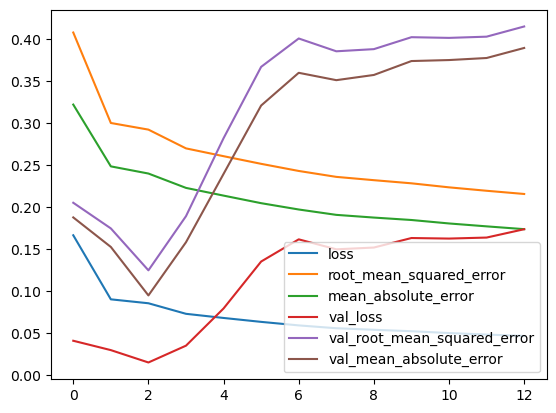

In [37]:
pd.DataFrame(history.history).plot()

In [38]:
model.load_weights(path_checkpoint)
# Re-evaluate the model
loss, mse, mae = model.evaluate(dataset_test, verbose=2)

4/4 - 0s - loss: 0.0149 - root_mean_squared_error: 0.1247 - mean_absolute_error: 0.0948 - 103ms/epoch - 26ms/step


In [39]:
def plot(input_data, predicted_data, output_compare, limit_right=None):
    if limit_right is not None:
        input_data = input_data[:limit_right]
        predicted_data = predicted_data[:limit_right]
        output_compare = output_compare[:limit_right]
        
    compare_y_shift = feature_sequence_length + forecasting_label_steps
    compare_y = list(range(compare_y_shift, compare_y_shift+ len(output_compare)))
    
    predicted_y_shift = feature_sequence_length + forecasting_label_steps
    predicted_y = list(range(predicted_y_shift, predicted_y_shift + len(predicted_data)))
    
    #input_data_limit = feature_sequence_length

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(predicted_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length-1], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [40]:
for x, y in dataset_test.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [41]:
for x, y in dataset_train.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [42]:
predicted_dataset_train = model.predict(dataset_train)

32/32 [==============================] - 1s 11ms/step


In [43]:
len(predicted_dataset_train)

320

In [44]:
len(predicted_dataset_train[:,0])

320

In [45]:
x_train_data[:,0]

array([0.1644748 , 0.18218482, 0.19673859, 0.22549537, 0.21725407,
       0.20164827, 0.2553042 , 0.27880067, 0.26933196, 0.301771  ,
       0.32982638, 0.3547255 , 0.34508154, 0.32526746, 0.3133439 ,
       0.35069263, 0.38085222, 0.36822724, 0.3692793 , 0.39540598,
       0.3789234 , 0.37787136, 0.41311586, 0.44993857, 0.4320533 ,
       0.39821145, 0.40259513, 0.40715417, 0.46449235, 0.5069261 ,
       0.4464317 , 0.4772927 , 0.44134665, 0.43222868, 0.4471331 ,
       0.4476591 , 0.45870587, 0.4395932 , 0.51762223, 0.64965814,
       0.77380323, 0.72032267, 0.86200243, 0.92319834, 1.        ,
       0.7399614 , 0.6894617 , 0.7487287 , 0.64194286, 0.52270734,
       0.49517795, 0.6375592 , 0.66771877, 0.79835176, 0.7788883 ,
       0.846572  , 0.834473  , 0.8695423 , 0.71786785, 0.6600035 ,
       0.7224268 , 0.59477466, 0.5735578 , 0.6431703 , 0.6202    ,
       0.5221813 , 0.5162196 , 0.55654913, 0.4841312 , 0.5945993 ,
       0.6601789 , 0.70541817, 0.72996664, 0.6300193 , 0.63036

In [46]:
# inverse transforms
normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0])
normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0])
normalizer_wti.inverse_transform_numpy_array(x_train_targets)

array([ 93.83,  91.78,  91.26,  92.11,  92.14,  92.77,  91.68,  96.13,
       103.66, 110.74, 107.69, 115.77, 119.26, 123.64, 108.81, 105.93,
       109.31, 103.22,  96.42,  94.85, 102.97, 104.69, 112.14, 111.03,
       114.89, 114.2 , 116.2 , 107.55, 104.25, 107.81, 100.53,  99.32,
       103.29, 101.98,  96.39,  96.05,  98.35,  94.22, 100.52, 104.26,
       106.84, 108.24, 102.54, 102.56, 103.89, 102.86,  99.6 , 102.62,
       101.96, 105.47, 104.59, 105.18, 102.53, 107.84, 108.17, 109.72,
       103.08,  99.74, 105.5 , 106.15, 110.52, 114.07, 112.31, 109.67,
       112.21, 112.63, 110.32, 112.55, 112.88, 116.19, 114.96, 114.38,
       115.26, 116.88, 118.97, 118.41, 119.55, 121.94, 121.52, 120.73,
       120.92, 118.92, 115.32, 117.56, 109.56, 110.49, 106.22, 105.75,
       109.07, 111.44, 113.66, 111.65, 107.76, 110.3 , 101.55, 100.31,
       104.62, 106.78, 106.09,  97.69,  98.44,  97.79,  99.59, 104.48,
       106.12, 104.45,  98.44,  97.71,  99.83,  97.74, 100.03,  99.11,
      

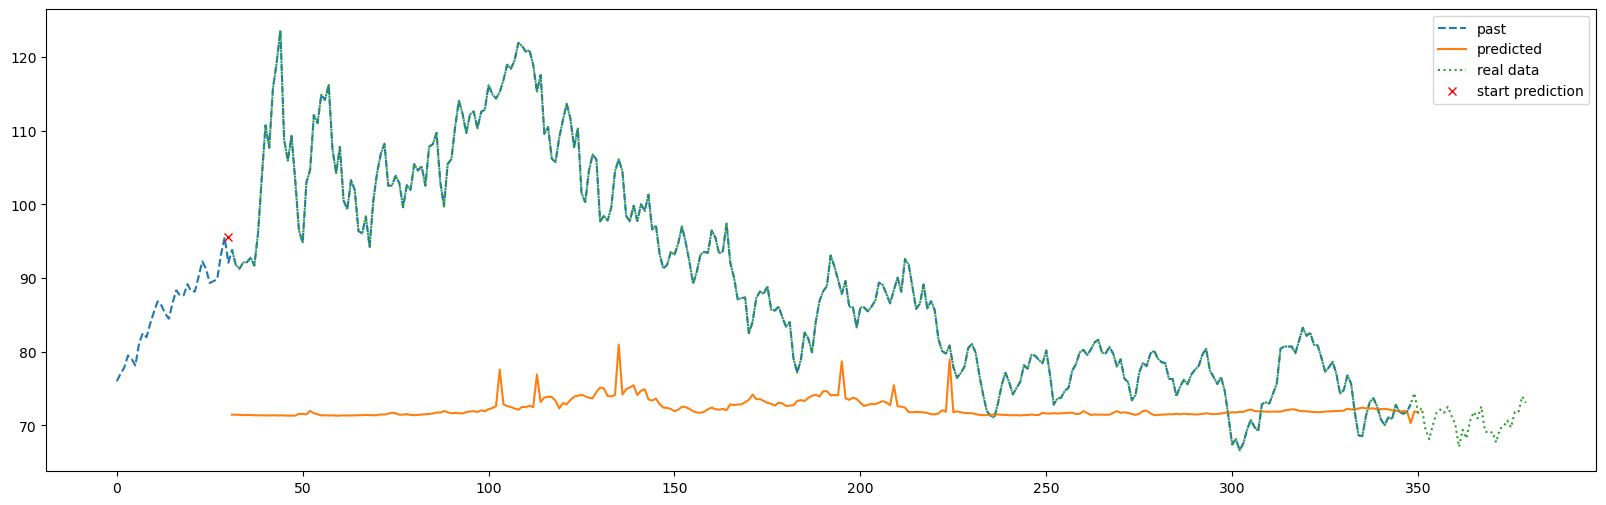

In [47]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0]),
    normalizer_wti.inverse_transform_numpy_array(x_train_targets)
    #limit_right=400
)

In [48]:
predicted_dataset_test = model.predict(dataset_test)

4/4 [==============================] - 0s 11ms/step


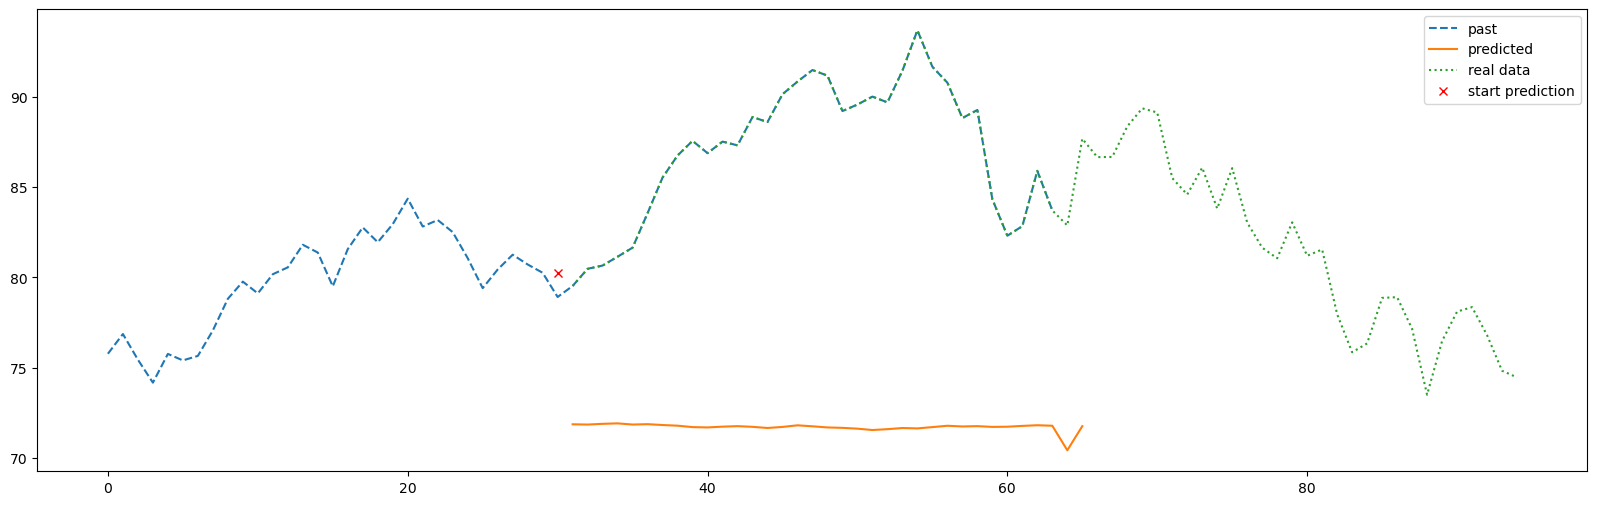

In [49]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_test_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_test[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_test_targets), 
    #limit_right=400
)